In [106]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import math
import geopandas as gpd
import csv

#import geoplot as gplt


from datetime import datetime
from pylab import *
from shapely.ops import nearest_points

In [123]:
df = pd.read_csv('clean_nyc_airbnb.csv')
df2 = pd.read_csv('clean_nyc_sale.csv')

In [143]:
#CALCULATE ANNUAL EARNING FROM AIRBNB
#assume the given occupnacy percentage
#assume: airbnb take 15%, maintainence 15% -> profit only 70%
df['annual_earn'] = df['price'] * 0.75 * df['occupancy_%']/100 * 365

In [145]:
#DROP AIRBNB WHERE SALE PRICE OF THAT AREA IS MOSTLY 0
df = df.loc[df['sale_median'] != 0]

In [149]:
#DEFINE COST OR MORTGAGE RATE
#THIS WILL BE DETERMINED BASED ON SALE_PRICE
#i.e. total sale price will determine total mortgage

#Assuming fixed annual interest rate

def mortgage_calculator(p, i, n):
    
    '''
    The function calculate the periodic payment
    input: initial payment p, fixed annual interest rate i, total number of payment n
    output: perdioc payment amount
    Example:
        initial payment: p = 500,000
        fixed annual interest rate: i = 2.75
        30-year-loan with yearly payment: n = 30
    '''
    
    if i > 0: 
        A = p * i / ( 1 - ( 1 + i ) ** (-n) )
    elif i == 0:
        A = p / n
    else:
        print("print please input positive anual interest rate i")
    return A   

#assume current fixed annual interest rate for 30year loan
#assume median price per neighbourhood as initial cost
n = 30
i = 0.031
no_i = 0.0

#add a mortgage column

# create a new column and use np.select to assign values to it using our lists as arguments
df.loc[:, 'annual_mortgage'] = df['sale_median'].apply(mortgage_calculator,args=(i, n))
df.loc[:, 'annual_cost'] = df['sale_median'].apply(mortgage_calculator,args=(no_i, n))

In [150]:
#performance = whether or revenue is positive or negative
df.loc[(df['annual_earn'] - df['annual_cost']) > 0, 'performance'] = 1
df.loc[(df['annual_earn'] - df['annual_cost']) < 0, 'performance'] = 0


In [151]:
#calculate ROI

df.loc[:, 'ROI_mortgage'] = ( df['annual_earn'] - df['annual_mortgage'] ) / df['annual_cost']
df.loc[:, 'ROI'] = ( df['annual_earn'] - df['annual_cost'] ) / df['annual_cost']

df[['ROI_mortgage','ROI']].describe()

,ROI_mortgage,ROI
count,25884.000000,25884.000000
mean,-0.536040,0.014389
std,1.308645,1.308645
min,-1.550429,-1.000000
25%,-1.183920,-0.633492
50%,-0.764017,-0.213588
75%,-0.193807,0.356622
max,126.665133,127.215561


In [152]:
#divide into types of houses
shared_room = df.loc[df['room_type'] == 'Shared room']
apt = df.loc[df['room_type'] == 'Entire home/apt']
private_room = df.loc[df['room_type'] == 'Private room']

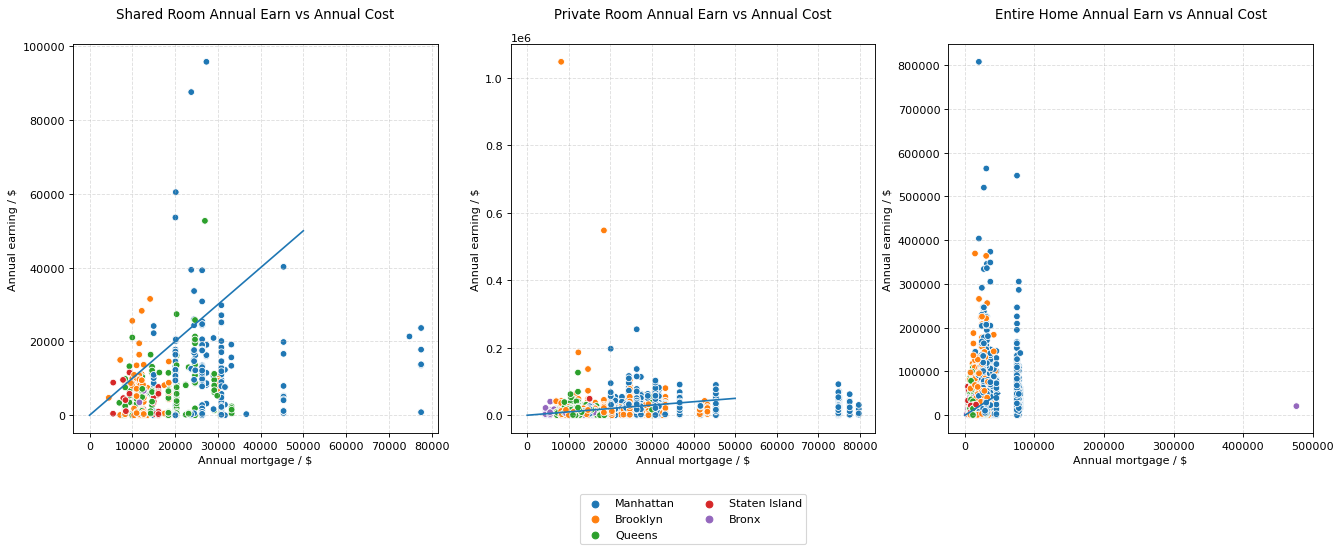

In [153]:
#PLOT ANNUAL MORTGAGE VS ANNUAL EARN


fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(top=0.8)

x = np.arange(50000)
y=x

### SHARED ROOM
ax1 = fig.add_subplot(131)
ax1 = sns.scatterplot(shared_room.annual_cost, shared_room.annual_earn, hue = shared_room.neighbourhood_group)
ax1.get_legend().remove()

plt.plot(x,y)
plt.title('Shared Room Annual Earn vs Annual Cost',y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual mortgage / $')
plt.grid(alpha=.4,linestyle='--')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


### PRIVATE ROOM
ax2 = fig.add_subplot(132)
ax2 = sns.scatterplot(private_room.annual_cost, private_room.annual_earn, hue = private_room.neighbourhood_group)

plt.plot(x,y)

plt.title('Private Room Annual Earn vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual mortgage / $')
plt.grid(alpha=.4,linestyle='--')

# Shrink current axis's height by 10% on the bottom
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#Edit legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[1:], labels=labels[1:], loc=8, 
          ncol=2, bbox_to_anchor=[0.5,-.3,0,0])


### ENTIRE HOME
ax3 = fig.add_subplot(133)
ax3 = sns.scatterplot(apt.annual_cost, apt.annual_earn, hue = apt.neighbourhood_group)
ax3.get_legend().remove()

plt.plot(x,y)
plt.title('Entire Home Annual Earn vs Annual Cost', y=1.05)
plt.ylabel('Annual earning / $')
plt.xlabel('Annual mortgage / $')
plt.grid(alpha=.4,linestyle='--')

box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.show()

In [154]:
#Only keep those with positive earning

shared_room = shared_room.loc[shared_room['performance'] == 1]
private_room = private_room.loc[private_room['performance'] == 1]
apt = apt.loc[apt['performance'] == 1]

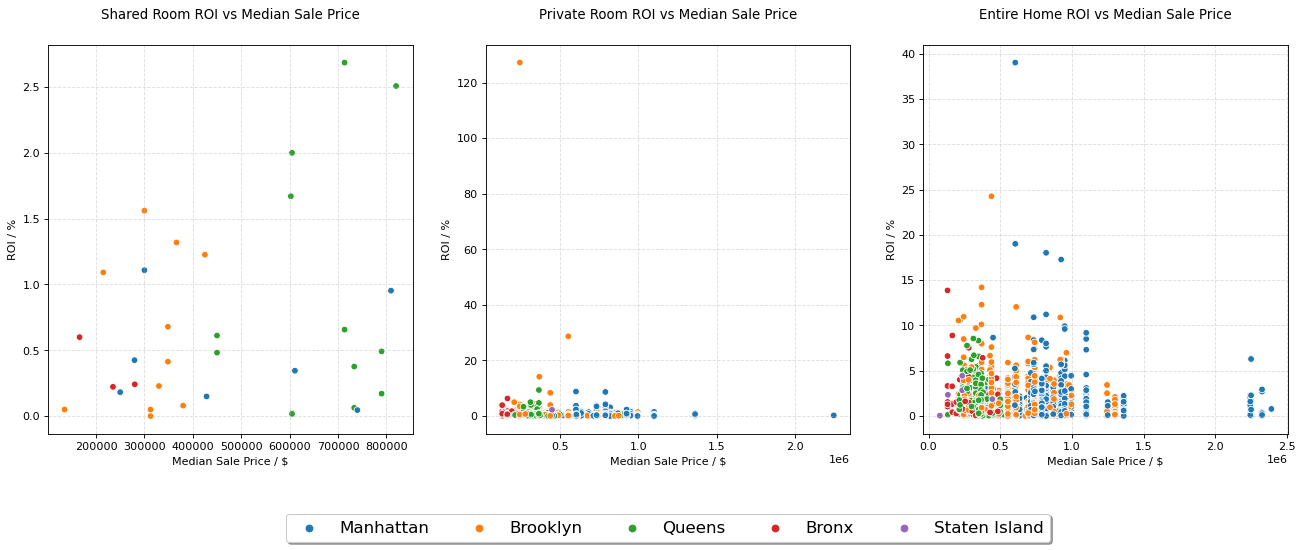

In [156]:
#PLOT ROI vs sale_median


fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(top=0.8)



### SHARED ROOM
ax1 = fig.add_subplot(131)
ax1 = sns.scatterplot(shared_room.sale_median, shared_room.ROI, hue = shared_room.neighbourhood_group)
ax1.get_legend().remove()


plt.title('Shared Room ROI vs Median Sale Price', y=1.05)
plt.ylabel('ROI / %')
plt.xlabel('Median Sale Price / $')
plt.grid(alpha=.4,linestyle='--')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


### PRIVATE ROOM
ax2 = fig.add_subplot(132)
ax2 = sns.scatterplot(private_room.sale_median, private_room.ROI, hue = private_room.neighbourhood_group)



plt.title('Private Room ROI vs Median Sale Price', y=1.05)
plt.ylabel('ROI / %')
plt.xlabel('Median Sale Price / $')
plt.grid(alpha=.4,linestyle='--')

# Shrink current axis's height by 10% on the bottom
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#Edit legend
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[1:], labels=labels[1:], loc=8, 
          ncol=5, bbox_to_anchor=[0.5,-.3,0,0], shadow = True, prop={"size":15})

### ENTIRE HOME
ax3 = fig.add_subplot(133)
ax3 = sns.scatterplot(apt.sale_median, apt.ROI, hue = apt.neighbourhood_group)
ax3.get_legend().remove()

plt.title('Entire Home ROI vs Median Sale Price', y=1.05)
plt.ylabel('ROI / %')
plt.xlabel('Median Sale Price / $')
plt.grid(alpha=.4,linestyle='--')

box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.show()